In [1]:
# Importing libraries for data manipulation
import sqlite3
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import numpy as np

# Importing libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Importing libraries for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Importing libraries for classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from py_helpers.pipeline_helper import *
from py_helpers.db_helper import *



In [2]:
"""
Define the list of attributes and table names
Example of how to fetch data from multiple tables
attributes = ["t1.attribute1", "t2.attribute2", "t3.attribute3", "t4.attribute4"] # Any attribute names that we want to fetch
table_names = ["table1", "table2", "table3", "table4"]  # The table names that we want to join
join_conditions = ["t1.id = t2.id", "t1.id = t3.id", "t1.id = t4.id"]  # The join conditions for the tables
"""
"""
# Fetching data from the database
attributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch
table_names = ["teams"]  # The table names that we want to join
join_conditions = []  # The join conditions for the tables

# Removing the table names from attributes
cleaned_attributes = [attr.split('.')[1] for attr in attributes]
"""

'\n# Fetching data from the database\nattributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch\ntable_names = ["teams"]  # The table names that we want to join\njoin_conditions = []  # The join conditions for the tables\n\n# Removing the table names from attributes\ncleaned_attributes = [attr.split(\'.\')[1] for attr in attributes]\n'

In [3]:
df = retrieve_data('./db/WNBA_cleared.db', 'merged')
df = df.drop(['tmID'], axis=1)
df.drop(['rank'], axis=1, inplace=True) # to good be true

# Shuffling the DataFrame
df = df.sample(frac=1, random_state=42) 

In [4]:
# Metrics to be used for evaluation of the model performance
metrics =  {
    'accuracy' : accuracy_score    # Accuracy -> bad with unbalanced data
    # 'precision' : precision_score,  # Precision -> good with unbalanced data (high precision means low false positives)
    # 'recall' : recall_score,        # Recall -> good with unbalanced data (high recall means low false negatives)
    # 'f1' : f1_score,                # F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
    # 'roc_auc' : roc_auc_score       # ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
}

In [5]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split

In [6]:
# Define the pipeline with different models

# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=seed))
])

# Dictionary of all the models
all_models =  { 'Logistic Regression' : model_lr, 
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [7]:
all_results = { 'sliding': [], 'expanding': [] , 'mixed' : []}

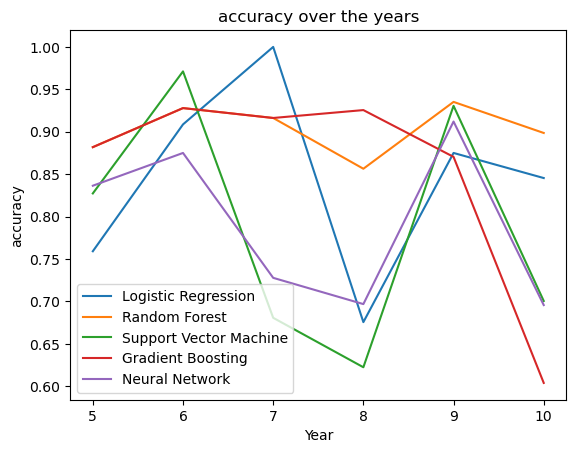

In [8]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 4 # Maybe test with different window sizes

start = 5

all_results['sliding'] = {}
for model_name, model in all_models.items():
    all_results['sliding'][model_name] = sliding_window_analysis(df, start, total_years, window_size, target, metrics, model)

plot_metrics_for_models(all_results['sliding'], all_models, start, total_years, metrics)

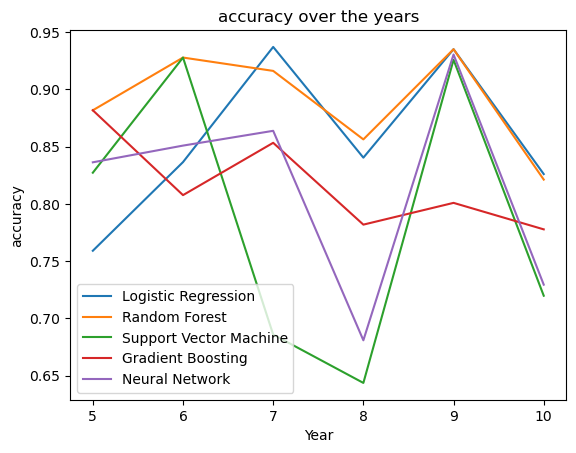

In [9]:
# Expanding window analysis
total_years = 10  # Total number of years that we have data for
start = 5 # Should be higher than 1 because we need to have at least 1 year of training data

all_results['expanding'] = {}
for model_name, model in all_models.items():
    all_results['expanding'][model_name] = expanding_window_analysis(df, start, total_years, target, metrics, model)

plot_metrics_for_models(all_results['expanding'], all_models, start, total_years, metrics)

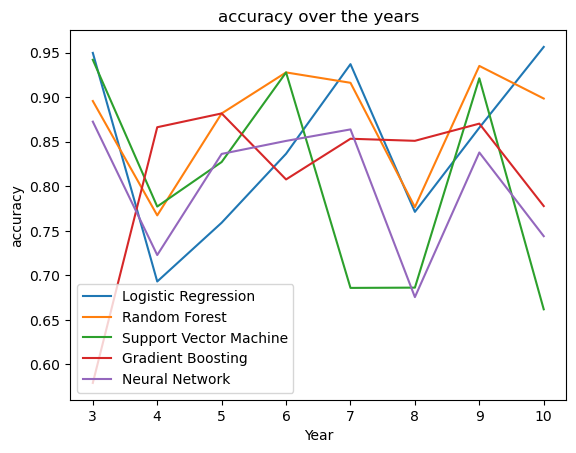

In [10]:
# Mixed window analysis
total_years = 10  # Total number of years that we have data for
start = 3  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 6  # Decide when to start sliding when predicting the 6th year

all_results['mixed'] = {}
for model_name, model in all_models.items():
    all_results['mixed'][model_name] = mixed_window_analysis(df, total_years, start, start_sliding, metrics, model, target)

plot_metrics_for_models(all_results['mixed'], all_models, start, total_years, metrics)

In [11]:
# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=seed))  # Increase max_iter
])

tuned_models =  { 'Logistic Regression' : model_lr,
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [12]:
# Hyperparameter grids for each model
param_grid_lr = {
    'classifier__penalty': ['l2'],  # Only 'l2' penalty with lbfgs solver
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


param_grid_svm = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_nn = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

param_grids = {
    'Logistic Regression': param_grid_lr,
    'Random Forest': param_grid_rf,
    'Support Vector Machine': param_grid_svm,
    'Gradient Boosting': param_grid_gb,
    'Neural Network': param_grid_nn
}

In [13]:
def tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding'):
    # Extract metrics for the specified model
    metrics = {'accuracy': accuracy_score}

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Perform sliding window analysis and store results
    if (window_type == 'sliding'):
        results = sliding_window_analysis(df, start, total_years, window_size, target, metrics, grid_search)
    elif (window_type == 'expanding'):
        results = expanding_window_analysis(df, start, total_years, target, metrics, grid_search)
    elif (window_type == 'mixed'):
        results = mixed_window_analysis(df, total_years, start, start_sliding, metrics, grid_search, target)

    # Output the best parameters from the grid search
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Output the mean and standard deviation of accuracy across all windows
    mean_accuracy = np.mean(results['accuracy'])
    std_accuracy = np.std(results['accuracy'])
    print(f"Mean accuracy: {mean_accuracy:.4f}, Standard deviation: {std_accuracy:.4f}")


    return results


Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8413, Standard deviation: 0.1003
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8978, Standard deviation: 0.0300
Best parameters for Support Vector Machine: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8374, Standard deviation: 0.1236
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8353, Standard deviation: 0.1173
Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.

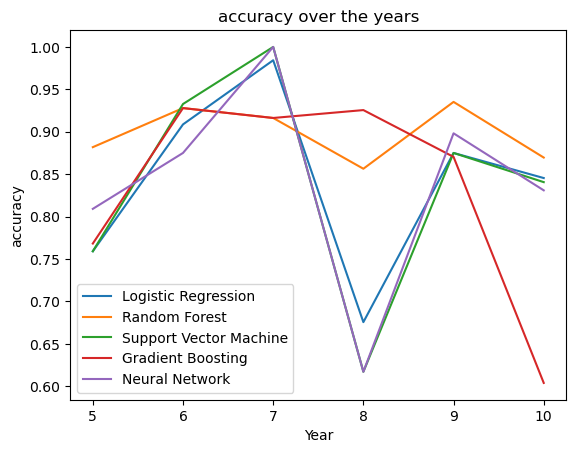

In [14]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


d:\Programas\CollegePrograms\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programas\CollegePrograms\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8496, Standard deviation: 0.0656
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8825, Standard deviation: 0.0542
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8010, Standard deviation: 0.0794
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mean accuracy: 0.7819, Standard deviation: 0.1759
Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.

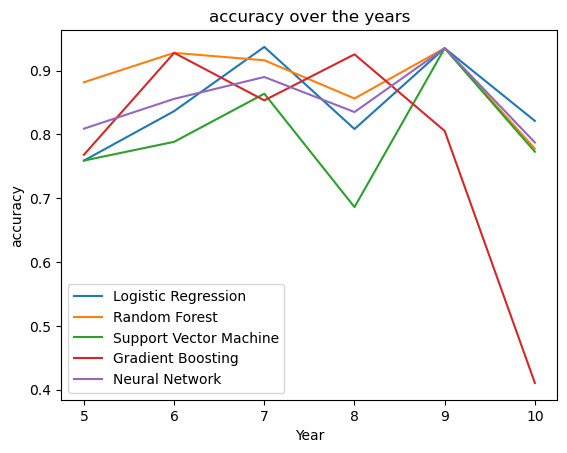

In [15]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='expanding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


d:\Programas\CollegePrograms\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8520, Standard deviation: 0.0718
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.9011, Standard deviation: 0.0278
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8227, Standard deviation: 0.0553
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mean accuracy: 0.7915, Standard deviation: 0.1477
Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.

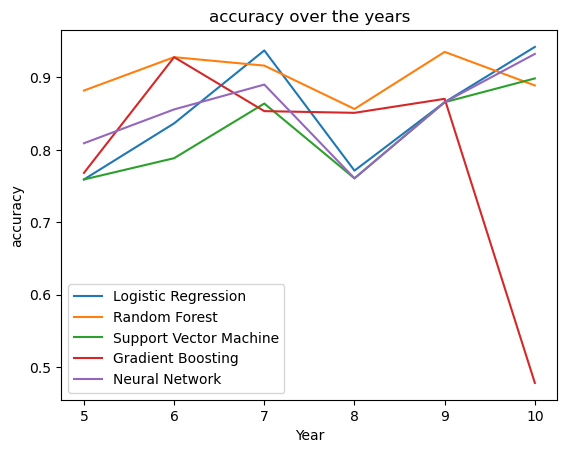

In [16]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='mixed')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)
